In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.20.0


In [2]:
import re
import pytest
import numpy as np
import pandas as pd
from skforecast.stats import Sarimax, Arar, Ets, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection._split import TimeSeriesFold
from skforecast.model_selection import backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt

# Fixtures
from skforecast.recursive.tests.tests_forecaster_stats.fixtures_forecaster_stats import y_datetime
from skforecast.recursive.tests.tests_forecaster_stats.fixtures_forecaster_stats import exog_datetime

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


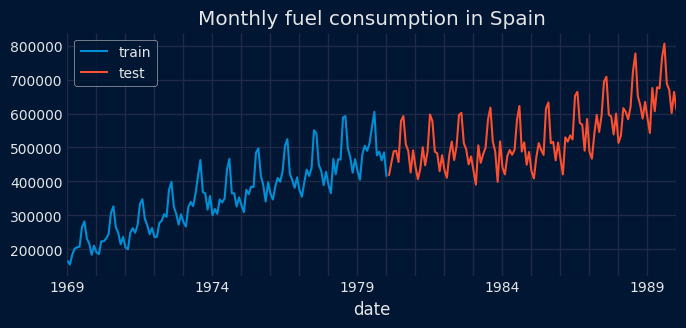

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [11]:
estimator_list = [
    Arima(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Arima(
        order=(1, 2, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Sarimax(
        order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=1000, method='cg', disp=False
    ),
    Ets(),
    Arar()
]

forecaster = ForecasterStats(estimator=estimator_list)

cv = TimeSeriesFold(
            steps                 = 10,
            initial_train_size    = len(data_train),
            refit                 = True,
            fixed_train_size      = False,
            gap                   = 0,
            allow_incomplete_fold = True
        )

metric, backtest_predictions = backtesting_stats(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    alpha      = None,
                                    interval   = None,
                                    n_jobs     = 1,
                                    verbose    = True
                                )

Information of folds
--------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 12
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1980-11-01 00:00:00  (n=10)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1980-11-01 00:00:00  (n=143)
    Validation: 1980-12-01 00:00:00 -- 1981-09-01 00:00:00  (n=10)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1981-09-01 00:00:00  (n=153)
    Validation: 1981-10-01 00:00:00 -- 1982-07-01 00:00:00  (n=10)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1982-07-01 00:00:00  (n=163)
    Validation: 1982-08-01 00:00:00 -- 1983-05-01 00:00:00  (n=10)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1983-05-01 00:00:00  (n=173)
    Validation: 1983-06

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\j

In [12]:
backtest_predictions.groupby('fold')['estimator_id'].nunique()

fold
0     5
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
Name: estimator_id, dtype: int64

In [13]:
backtest_predictions

,fold,estimator_id,pred
1980-02-01,0,skforecast.Arima,422818.741790
1980-03-01,0,skforecast.Arima,486542.442588
1980-04-01,0,skforecast.Arima,487963.076806
1980-05-01,0,skforecast.Arima,497239.623530
1980-06-01,0,skforecast.Arima,510518.327651
...,...,...,...
1989-09-01,11,skforecast.Arar,686341.225679
1989-10-01,11,skforecast.Arar,662208.960606
1989-11-01,11,skforecast.Arar,617807.050197
1989-12-01,11,skforecast.Arar,669662.281322


In [ ]:
refit = 0

if not refit:
    print(1)
else:
    print(2)

1


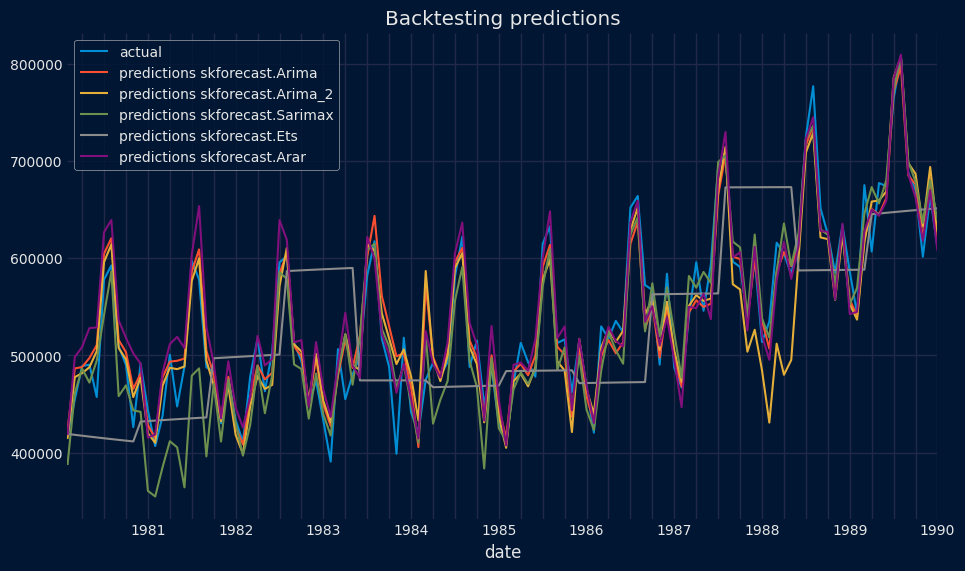

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
data_test['y'].plot(ax=ax, label='actual')
for est in backtest_predictions['estimator_id'].unique():
    preds = backtest_predictions.loc[
        backtest_predictions['estimator_id'] == est, 'pred'
    ]
    preds.plot(ax=ax, label=f'predictions {est}')
ax.set_title('Backtesting predictions')
ax.legend();

In [7]:
metric

,mean_squared_error
0,1.241207e+10
